In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
df=pd.read_csv('/content/drive/MyDrive/Multimodal-Fake-News-Detection/merged_dataset.csv')
df.head()

,ID,url,text,images,top_img,authors,label,word_count,domain,tokens,image_name,caption
0,1,http://www.eonline.com/news/901683/janet-jacks...,janet jackson and jermaine dupri are hooking u...,https://akns-images.eonline.com/eol_images/Ent...,https://akns-images.eonline.com/eol_images/Ent...,Unknown,0,119,No Domain,"['janet', 'jackson', 'and', 'jermaine', 'dupri...",1,a man and woman posing for a picture
1,2,http://www.yourtango.com/2018311123/7-cringey-...,katy perry and orlando bloom are a celeb coupl...,http://www.yourtango.com/sites/default/files/2...,https://www.yourtango.com/sites/default/files/...,Unknown,0,1205,No Domain,"['katy', 'perry', 'and', 'orlando', 'bloom', '...",2,a woman in a white dress is standing in front ...
2,3,http://pagesix.com/2018/07/05/vanessa-kirby-sh...,two years into a relationship with her boyfrie...,https://pagesix.com/wp-content/uploads/sites/3...,https://pagesix.com/wp-content/uploads/sites/3...,Unknown,0,230,No Domain,"['two', 'years', 'into', 'a', 'relationship', ...",3,a man and woman standing next to each other pe...
3,4,http://www.inquisitr.com/4780146/miranda-lambe...,it s been more than two years since miranda la...,https://www.inquisitr.com/wp-content/uploads/2...,https://www.inquisitr.com/wp-content/uploads/2...,News Writer,0,380,No Domain,"['it', 's', 'been', 'more', 'than', 'two', 'ye...",4,a logo for a company that sells and sells prod...
4,5,http://toofab.com/2017/11/19/selena-gomez-debu...,getty selena gomez showed up to the american m...,https://images.toofab.com/image/ae/5by6/2025/0...,https://images.toofab.com/image/22/16by9/2017/...,Toofab Staff,0,396,No Domain,"['getty', 'selena', 'gomez', 'showed', 'up', '...",5,miled - miled - miled - miled - miled - miled ...


In [3]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split

# ========== CONFIG ==========
MAX_LEN = 128
BATCH_SIZE = 16
BERT_MODEL = 'bert-base-uncased'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ========== DATASET ==========
class NewsDataset(Dataset):
    def __init__(self, texts, captions, labels, tokenizer, max_len):
        self.texts = texts
        self.captions = captions
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        #print(f"Accessing index: {item}")  # يمكن تفعيلها للتصحيح
        text = str(self.texts[item])
        caption = str(self.captions[item])
        label = int(self.labels[item])

        # Tokenize text and caption
        text_inputs = self.tokenizer(text, padding='max_length', truncation=True,
                                     max_length=self.max_len, return_tensors="pt")
        caption_inputs = self.tokenizer(caption, padding='max_length', truncation=True,
                                        max_length=self.max_len, return_tensors="pt")

        return {
            'text_input_ids': text_inputs['input_ids'].squeeze(0),
            'text_attention_mask': text_inputs['attention_mask'].squeeze(0),
            'caption_input_ids': caption_inputs['input_ids'].squeeze(0),
            'caption_attention_mask': caption_inputs['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

# ========== MODEL ==========
class EarlyFusionClassifier(nn.Module):
    def __init__(self, bert_model):
        super(EarlyFusionClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model)
        self.dropout = nn.Dropout(0.6)
        self.fc = nn.Linear(self.bert.config.hidden_size * 2, 1)

    def forward(self, text_ids, text_mask, caption_ids, caption_mask):
        # Get BERT embeddings for text and caption
        text_output = self.bert(input_ids=text_ids, attention_mask=text_mask).pooler_output
        caption_output = self.bert(input_ids=caption_ids, attention_mask=caption_mask).pooler_output

        # Early fusion (concatenation)
        fused = torch.cat((text_output, caption_output), dim=1)
        fused = self.dropout(fused)
        out = self.fc(fused)
        return out

# ========== TRAINING UTILITIES ==========
def train_epoch(model, data_loader, loss_fn, optimizer):
    model.train()
    losses = []
    correct = 0

    for batch in data_loader:
        text_ids = batch['text_input_ids'].to(DEVICE)
        text_mask = batch['text_attention_mask'].to(DEVICE)
        caption_ids = batch['caption_input_ids'].to(DEVICE)
        caption_mask = batch['caption_attention_mask'].to(DEVICE)
        labels = batch['label'].to(DEVICE)

        outputs = model(text_ids, text_mask, caption_ids, caption_mask).squeeze(-1)
        loss = loss_fn(outputs, labels.float())

        preds = torch.sigmoid(outputs) > 0.5
        correct += (preds == labels).sum().item()
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return correct / len(data_loader.dataset), sum(losses) / len(losses)

def evaluate(model, data_loader, loss_fn):
    model.eval()
    correct = 0
    losses = []

    with torch.no_grad():
        for batch in data_loader:
            text_ids = batch['text_input_ids'].to(DEVICE)
            text_mask = batch['text_attention_mask'].to(DEVICE)
            caption_ids = batch['caption_input_ids'].to(DEVICE)
            caption_mask = batch['caption_attention_mask'].to(DEVICE)
            labels = batch['label'].to(DEVICE)

            outputs = model(text_ids, text_mask, caption_ids, caption_mask).squeeze(-1)
            loss = loss_fn(outputs, labels.float())
            losses.append(loss.item())

            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == labels).sum().item()

    accuracy = correct / len(data_loader.dataset)
    avg_loss = sum(losses) / len(losses)
    return accuracy, avg_loss

# ========== MAIN FUNCTION ==========
def main(csv_path):
    # Load dataset
    df = pd.read_csv(csv_path)

    # Reset index to avoid indexing issues
    df = df.reset_index(drop=True)

    # Check for missing data in critical columns
    print(df[['text', 'caption', 'label']].isnull().sum())

    # Drop rows with missing data in important columns
    df = df.dropna(subset=['text', 'caption', 'label'])

    # Split dataset
    train_texts, val_texts, train_captions, val_captions, train_labels, val_labels = train_test_split(
        df['text'], df['caption'], df['label'], test_size=0.2, random_state=42)

    # Reset the indices after splitting
    train_texts = train_texts.reset_index(drop=True)
    val_texts = val_texts.reset_index(drop=True)
    train_captions = train_captions.reset_index(drop=True)
    val_captions = val_captions.reset_index(drop=True)
    train_labels = train_labels.reset_index(drop=True)
    val_labels = val_labels.reset_index(drop=True)

    # Load tokenizer
    tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)

    # Create datasets
    train_dataset = NewsDataset(train_texts, train_captions, train_labels, tokenizer, MAX_LEN)
    val_dataset = NewsDataset(val_texts, val_captions, val_labels, tokenizer, MAX_LEN)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    # Initialize model, optimizer, and loss function
    model = EarlyFusionClassifier(BERT_MODEL).to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    loss_fn = nn.BCEWithLogitsLoss()

    # Training loop
    for epoch in range(20):
        train_acc, train_loss = train_epoch(model, train_loader, loss_fn, optimizer)
        val_acc, val_loss = evaluate(model, val_loader, loss_fn)
        print(f"Epoch {epoch+1}: Train Accuracy = {train_acc:.4f}, Train Loss = {train_loss:.4f}")
        print(f"Epoch {epoch+1}: Val Accuracy = {val_acc:.4f}, Val Loss = {val_loss:.4f}")

if __name__ == "__main__":
    main("/content/drive/MyDrive/Multimodal-Fake-News-Detection/merged_dataset.csv")


text       0
caption    0
label      0
dtype: int64


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1: Train Accuracy = 0.6251, Train Loss = 0.6289
Epoch 1: Val Accuracy = 0.7230, Val Loss = 0.5485
Epoch 2: Train Accuracy = 0.7763, Train Loss = 0.4695
Epoch 2: Val Accuracy = 0.7527, Val Loss = 0.4919
Epoch 3: Train Accuracy = 0.8614, Train Loss = 0.3215
Epoch 3: Val Accuracy = 0.7671, Val Loss = 0.5596
Epoch 4: Train Accuracy = 0.9311, Train Loss = 0.1874
Epoch 4: Val Accuracy = 0.7545, Val Loss = 0.6905
Epoch 5: Train Accuracy = 0.9622, Train Loss = 0.1088
Epoch 5: Val Accuracy = 0.7266, Val Loss = 0.9040
Epoch 6: Train Accuracy = 0.9642, Train Loss = 0.0950
Epoch 6: Val Accuracy = 0.7455, Val Loss = 0.7587
Epoch 7: Train Accuracy = 0.9804, Train Loss = 0.0533
Epoch 7: Val Accuracy = 0.7527, Val Loss = 0.9345
Epoch 8: Train Accuracy = 0.9806, Train Loss = 0.0508
Epoch 8: Val Accuracy = 0.7428, Val Loss = 1.0205


KeyboardInterrupt: 

In [4]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split

# ========== CONFIG ==========
MAX_LEN = 128
BATCH_SIZE = 16
BERT_MODEL = 'bert-base-uncased'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ========== DATASET ==========
class NewsDataset(Dataset):
    def __init__(self, texts, captions, labels, tokenizer, max_len):
        self.texts = texts
        self.captions = captions
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        #print(f"Accessing index: {item}")  # يمكن تفعيلها للتصحيح
        text = str(self.texts[item])
        caption = str(self.captions[item])
        label = int(self.labels[item])

        # Tokenize text and caption
        text_inputs = self.tokenizer(text, padding='max_length', truncation=True,
                                     max_length=self.max_len, return_tensors="pt")
        caption_inputs = self.tokenizer(caption, padding='max_length', truncation=True,
                                        max_length=self.max_len, return_tensors="pt")

        return {
            'text_input_ids': text_inputs['input_ids'].squeeze(0),
            'text_attention_mask': text_inputs['attention_mask'].squeeze(0),
            'caption_input_ids': caption_inputs['input_ids'].squeeze(0),
            'caption_attention_mask': caption_inputs['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

# ========== MODEL ==========
class EarlyFusionClassifier(nn.Module):
    def __init__(self, bert_model):
        super(EarlyFusionClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model)
        self.dropout = nn.Dropout(0.6)
        self.fc = nn.Linear(self.bert.config.hidden_size * 2, 1)

    def forward(self, text_ids, text_mask, caption_ids, caption_mask):
        # Get BERT embeddings for text and caption
        text_output = self.bert(input_ids=text_ids, attention_mask=text_mask).pooler_output
        caption_output = self.bert(input_ids=caption_ids, attention_mask=caption_mask).pooler_output

        # Early fusion (concatenation)
        fused = torch.cat((text_output, caption_output), dim=1)
        fused = self.dropout(fused)
        out = self.fc(fused)
        return out

# ========== TRAINING UTILITIES ==========
def train_epoch(model, data_loader, loss_fn, optimizer):
    model.train()
    losses = []
    correct = 0

    for batch in data_loader:
        text_ids = batch['text_input_ids'].to(DEVICE)
        text_mask = batch['text_attention_mask'].to(DEVICE)
        caption_ids = batch['caption_input_ids'].to(DEVICE)
        caption_mask = batch['caption_attention_mask'].to(DEVICE)
        labels = batch['label'].to(DEVICE)

        outputs = model(text_ids, text_mask, caption_ids, caption_mask).squeeze(-1)
        loss = loss_fn(outputs, labels.float())

        preds = torch.sigmoid(outputs) > 0.5
        correct += (preds == labels).sum().item()
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return correct / len(data_loader.dataset), sum(losses) / len(losses)

def evaluate(model, data_loader, loss_fn):
    model.eval()
    correct = 0
    losses = []

    with torch.no_grad():
        for batch in data_loader:
            text_ids = batch['text_input_ids'].to(DEVICE)
            text_mask = batch['text_attention_mask'].to(DEVICE)
            caption_ids = batch['caption_input_ids'].to(DEVICE)
            caption_mask = batch['caption_attention_mask'].to(DEVICE)
            labels = batch['label'].to(DEVICE)

            outputs = model(text_ids, text_mask, caption_ids, caption_mask).squeeze(-1)
            loss = loss_fn(outputs, labels.float())
            losses.append(loss.item())

            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == labels).sum().item()

    accuracy = correct / len(data_loader.dataset)
    avg_loss = sum(losses) / len(losses)
    return accuracy, avg_loss

# ========== MAIN FUNCTION ==========
def main(csv_path):
    # Load dataset
    df = pd.read_csv(csv_path)

    # Reset index to avoid indexing issues
    df = df.reset_index(drop=True)

    # Check for missing data in critical columns
    print(df[['text', 'caption', 'label']].isnull().sum())

    # Drop rows with missing data in important columns
    df = df.dropna(subset=['text', 'caption', 'label'])

    # Split dataset
    train_texts, val_texts, train_captions, val_captions, train_labels, val_labels = train_test_split(
        df['text'], df['caption'], df['label'], test_size=0.2, random_state=42)

    # Reset the indices after splitting
    train_texts = train_texts.reset_index(drop=True)
    val_texts = val_texts.reset_index(drop=True)
    train_captions = train_captions.reset_index(drop=True)
    val_captions = val_captions.reset_index(drop=True)
    train_labels = train_labels.reset_index(drop=True)
    val_labels = val_labels.reset_index(drop=True)

    # Load tokenizer
    tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)

    # Create datasets
    train_dataset = NewsDataset(train_texts, train_captions, train_labels, tokenizer, MAX_LEN)
    val_dataset = NewsDataset(val_texts, val_captions, val_labels, tokenizer, MAX_LEN)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    # Initialize model, optimizer, and loss function
    model = EarlyFusionClassifier(BERT_MODEL).to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    loss_fn = nn.BCEWithLogitsLoss()

    # Training loop
    for epoch in range(20):
        train_acc, train_loss = train_epoch(model, train_loader, loss_fn, optimizer)
        val_acc, val_loss = evaluate(model, val_loader, loss_fn)
        print(f"Epoch {epoch+1}: Train Accuracy = {train_acc:.4f}, Train Loss = {train_loss:.4f}")
        print(f"Epoch {epoch+1}: Val Accuracy = {val_acc:.4f}, Val Loss = {val_loss:.4f}")

if __name__ == "__main__":
    main("/content/drive/MyDrive/Multimodal-Fake-News-Detection/merged_dataset.csv")


text       0
caption    0
label      0
dtype: int64
Epoch 1: Train Accuracy = 0.6751, Train Loss = 0.6032
Epoch 1: Val Accuracy = 0.7482, Val Loss = 0.5107
Epoch 2: Train Accuracy = 0.7934, Train Loss = 0.4538
Epoch 2: Val Accuracy = 0.7455, Val Loss = 0.5478
Epoch 3: Train Accuracy = 0.8774, Train Loss = 0.3130
Epoch 3: Val Accuracy = 0.7482, Val Loss = 0.5926
Epoch 4: Train Accuracy = 0.9338, Train Loss = 0.1946
Epoch 4: Val Accuracy = 0.7284, Val Loss = 0.6850
Epoch 5: Train Accuracy = 0.9530, Train Loss = 0.1437
Epoch 5: Val Accuracy = 0.7482, Val Loss = 0.6973
Epoch 6: Train Accuracy = 0.9739, Train Loss = 0.0819
Epoch 6: Val Accuracy = 0.7338, Val Loss = 0.9288
Epoch 7: Train Accuracy = 0.9721, Train Loss = 0.0774
Epoch 7: Val Accuracy = 0.7545, Val Loss = 0.8895
Epoch 8: Train Accuracy = 0.9793, Train Loss = 0.0636
Epoch 8: Val Accuracy = 0.7347, Val Loss = 1.0209
Epoch 9: Train Accuracy = 0.9761, Train Loss = 0.0606
Epoch 9: Val Accuracy = 0.7536, Val Loss = 0.9854
Epoch 10: Tr

KeyboardInterrupt: 

Length of dataframe: 5556
Length of embeddings: 5556
Train texts length: 4444, Train glove embeddings length: 4444
Validation texts length: 1112, Validation glove embeddings length: 1112

Epoch 1/20
Train Acc: 0.6609, Train Loss: 0.6028
Val   Acc: 0.7554, Val   Loss: 0.5056

Epoch 2/20
Train Acc: 0.7910, Train Loss: 0.4587
Val   Acc: 0.7653, Val   Loss: 0.4909

Epoch 3/20
Train Acc: 0.8423, Train Loss: 0.3659
Val   Acc: 0.7536, Val   Loss: 0.5185
EarlyStopping counter: 1 out of 3

Epoch 4/20
Train Acc: 0.8947, Train Loss: 0.2658
Val   Acc: 0.7572, Val   Loss: 0.5947
EarlyStopping counter: 2 out of 3

Epoch 5/20
Train Acc: 0.9388, Train Loss: 0.1780
Val   Acc: 0.7518, Val   Loss: 0.7239
EarlyStopping counter: 3 out of 3
⛔ Early stopping triggered.


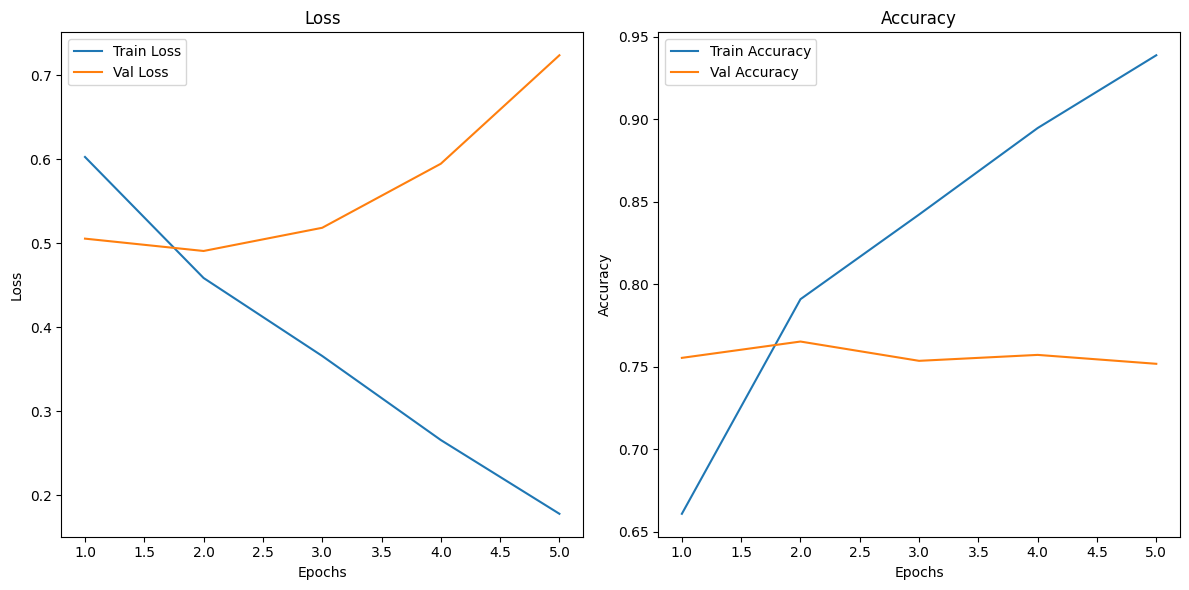

In [8]:
# ==================== CONFIG ====================
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

MAX_LEN = 128
BATCH_SIZE = 16
BERT_MODEL = 'bert-base-uncased'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 20
PATIENCE = 3

# ==================== LOAD GLOVE EMBEDDINGS ====================
captions_glove = np.load('/content/drive/MyDrive/Multimodal-Fake-News-Detection/captions_embeddings.npy')

# ==================== DATASET ====================
class NewsDatasetWithGlove(Dataset):
    def __init__(self, texts, caption_embeddings, labels, tokenizer, max_len):
        self.texts = texts
        self.caption_embeddings = caption_embeddings
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        caption_embed = self.caption_embeddings[idx]

        text_inputs = self.tokenizer(text, padding='max_length', truncation=True,
                                     max_length=self.max_len, return_tensors="pt")

        return {
            'text_input_ids': text_inputs['input_ids'].squeeze(0),
            'text_attention_mask': text_inputs['attention_mask'].squeeze(0),
            'caption_embed': torch.tensor(caption_embed, dtype=torch.float),
            'label': torch.tensor(label, dtype=torch.long)
        }

# ==================== MODEL ====================
class EarlyFusionClassifierGlove(nn.Module):
    def __init__(self, bert_model):
        super(EarlyFusionClassifierGlove, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model)
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(self.bert.config.hidden_size + 300, 1)

    def forward(self, text_ids, text_mask, caption_embed):
        text_output = self.bert(input_ids=text_ids, attention_mask=text_mask).pooler_output
        fused = torch.cat((text_output, caption_embed), dim=1)
        fused = self.dropout(fused)
        return self.fc(fused)

# ==================== EARLY STOPPING ====================
class EarlyStopping:
    def __init__(self, patience=PATIENCE, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# ==================== TRAINING FUNCTIONS ====================
def train_epoch_glove(model, data_loader, loss_fn, optimizer):
    model.train()
    total_loss, correct = 0, 0

    for batch in data_loader:
        text_ids = batch['text_input_ids'].to(DEVICE)
        text_mask = batch['text_attention_mask'].to(DEVICE)
        caption_embed = batch['caption_embed'].to(DEVICE)
        labels = batch['label'].to(DEVICE)

        outputs = model(text_ids, text_mask, caption_embed).squeeze(-1)
        loss = loss_fn(outputs, labels.float())

        preds = torch.sigmoid(outputs) > 0.5
        correct += (preds == labels).sum().item()
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return correct / len(data_loader.dataset), total_loss / len(data_loader)

def evaluate_glove(model, data_loader, loss_fn):
    model.eval()
    total_loss, correct = 0, 0

    with torch.no_grad():
        for batch in data_loader:
            text_ids = batch['text_input_ids'].to(DEVICE)
            text_mask = batch['text_attention_mask'].to(DEVICE)
            caption_embed = batch['caption_embed'].to(DEVICE)
            labels = batch['label'].to(DEVICE)

            outputs = model(text_ids, text_mask, caption_embed).squeeze(-1)
            loss = loss_fn(outputs, labels.float())
            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == labels).sum().item()
            total_loss += loss.item()

    return correct / len(data_loader.dataset), total_loss / len(data_loader)

# ==================== MAIN FUNCTION ====================
def main(csv_path):
    df = pd.read_csv(csv_path)
    df = df.reset_index(drop=True)
    df = df.dropna(subset=['text', 'caption', 'label'])

    glove_embeddings = np.load('/content/drive/MyDrive/Multimodal-Fake-News-Detection/captions_embeddings.npy')

    print(f"Length of dataframe: {len(df)}")
    print(f"Length of embeddings: {glove_embeddings.shape[0]}")
    assert len(df) == glove_embeddings.shape[0], "Mismatch between DataFrame rows and embeddings length!"

    train_texts, val_texts, train_glove, val_glove, train_labels, val_labels = train_test_split(
        df['text'], glove_embeddings, df['label'], test_size=0.2, random_state=42)

    # إعادة تعيين الفهارس للنصوص والتسميات (بيانات pandas)
    train_texts = train_texts.reset_index(drop=True)
    val_texts = val_texts.reset_index(drop=True)
    train_labels = train_labels.reset_index(drop=True)
    val_labels = val_labels.reset_index(drop=True)

    print(f"Train texts length: {len(train_texts)}, Train glove embeddings length: {train_glove.shape[0]}")
    print(f"Validation texts length: {len(val_texts)}, Validation glove embeddings length: {val_glove.shape[0]}")

    tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)

    train_dataset = NewsDatasetWithGlove(train_texts, train_glove, train_labels, tokenizer, MAX_LEN)
    val_dataset = NewsDatasetWithGlove(val_texts, val_glove, val_labels, tokenizer, MAX_LEN)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    model = EarlyFusionClassifierGlove(BERT_MODEL).to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=5e-3)
    loss_fn = nn.BCEWithLogitsLoss()
    early_stopping = EarlyStopping(patience=PATIENCE, verbose=True)

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch + 1}/{EPOCHS}")
        train_acc, train_loss = train_epoch_glove(model, train_loader, loss_fn, optimizer)
        val_acc, val_loss = evaluate_glove(model, val_loader, loss_fn)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Train Acc: {train_acc:.4f}, Train Loss: {train_loss:.4f}")
        print(f"Val   Acc: {val_acc:.4f}, Val   Loss: {val_loss:.4f}")

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("⛔ Early stopping triggered.")
            break

    # رسم النتائج
    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Val Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# ==================== RUN ====================
if __name__ == "__main__":
    main("/content/drive/MyDrive/Multimodal-Fake-News-Detection/merged_dataset.csv")


Length of dataframe: 5556
Length of embeddings: 5556
Train texts length: 4444, Train glove embeddings length: 4444
Validation texts length: 1112, Validation glove embeddings length: 1112

Epoch 1/20
Train Acc: 0.5583, Train Loss: 0.6832
Val   Acc: 0.6592, Val   Loss: 0.6011

Epoch 2/20
Train Acc: 0.7329, Train Loss: 0.5307
Val   Acc: 0.7617, Val   Loss: 0.4933

Epoch 3/20
Train Acc: 0.8085, Train Loss: 0.4238
Val   Acc: 0.7590, Val   Loss: 0.4876

Epoch 4/20
Train Acc: 0.8762, Train Loss: 0.3031
Val   Acc: 0.7491, Val   Loss: 0.5712
EarlyStopping counter: 1 out of 3

Epoch 5/20
Train Acc: 0.9251, Train Loss: 0.1989
Val   Acc: 0.7572, Val   Loss: 0.6784
EarlyStopping counter: 2 out of 3

Epoch 6/20
Train Acc: 0.9584, Train Loss: 0.1261
Val   Acc: 0.7464, Val   Loss: 0.8315
EarlyStopping counter: 3 out of 3
⛔ Early stopping triggered.


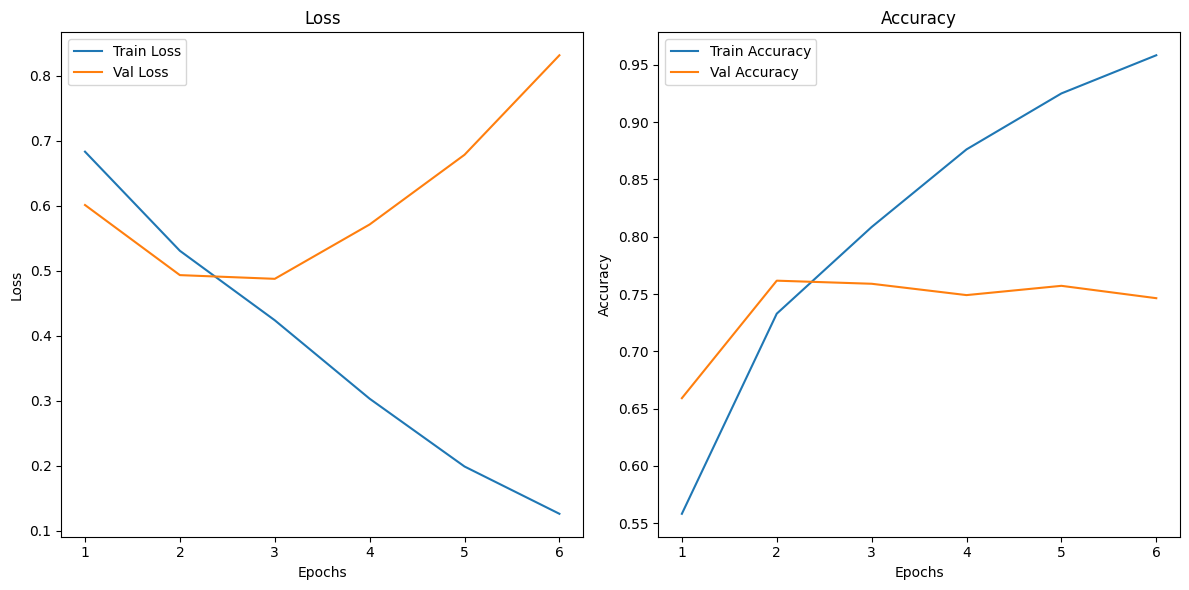

In [9]:
# ==================== CONFIG ====================
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

MAX_LEN = 128
BATCH_SIZE = 16
BERT_MODEL = 'bert-base-uncased'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 20
PATIENCE = 3

# ==================== LOAD GLOVE EMBEDDINGS ====================
captions_glove = np.load('/content/drive/MyDrive/Multimodal-Fake-News-Detection/captions_embeddings.npy')

# ==================== DATASET ====================
class NewsDatasetWithGlove(Dataset):
    def __init__(self, texts, caption_embeddings, labels, tokenizer, max_len):
        self.texts = texts
        self.caption_embeddings = caption_embeddings
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        caption_embed = self.caption_embeddings[idx]

        text_inputs = self.tokenizer(text, padding='max_length', truncation=True,
                                     max_length=self.max_len, return_tensors="pt")

        return {
            'text_input_ids': text_inputs['input_ids'].squeeze(0),
            'text_attention_mask': text_inputs['attention_mask'].squeeze(0),
            'caption_embed': torch.tensor(caption_embed, dtype=torch.float),
            'label': torch.tensor(label, dtype=torch.long)
        }

# ==================== MODEL ====================
class EarlyFusionClassifierGlove(nn.Module):
    def __init__(self, bert_model):
        super(EarlyFusionClassifierGlove, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model)
        self.dropout = nn.Dropout(0.6)
        self.fc = nn.Linear(self.bert.config.hidden_size + 300, 1)

    def forward(self, text_ids, text_mask, caption_embed):
        text_output = self.bert(input_ids=text_ids, attention_mask=text_mask).pooler_output
        fused = torch.cat((text_output, caption_embed), dim=1)
        fused = self.dropout(fused)
        return self.fc(fused)

# ==================== EARLY STOPPING ====================
class EarlyStopping:
    def __init__(self, patience=PATIENCE, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# ==================== TRAINING FUNCTIONS ====================
def train_epoch_glove(model, data_loader, loss_fn, optimizer):
    model.train()
    total_loss, correct = 0, 0

    for batch in data_loader:
        text_ids = batch['text_input_ids'].to(DEVICE)
        text_mask = batch['text_attention_mask'].to(DEVICE)
        caption_embed = batch['caption_embed'].to(DEVICE)
        labels = batch['label'].to(DEVICE)

        outputs = model(text_ids, text_mask, caption_embed).squeeze(-1)
        loss = loss_fn(outputs, labels.float())

        preds = torch.sigmoid(outputs) > 0.5
        correct += (preds == labels).sum().item()
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return correct / len(data_loader.dataset), total_loss / len(data_loader)

def evaluate_glove(model, data_loader, loss_fn):
    model.eval()
    total_loss, correct = 0, 0

    with torch.no_grad():
        for batch in data_loader:
            text_ids = batch['text_input_ids'].to(DEVICE)
            text_mask = batch['text_attention_mask'].to(DEVICE)
            caption_embed = batch['caption_embed'].to(DEVICE)
            labels = batch['label'].to(DEVICE)

            outputs = model(text_ids, text_mask, caption_embed).squeeze(-1)
            loss = loss_fn(outputs, labels.float())
            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == labels).sum().item()
            total_loss += loss.item()

    return correct / len(data_loader.dataset), total_loss / len(data_loader)

# ==================== MAIN FUNCTION ====================
def main(csv_path):
    df = pd.read_csv(csv_path)
    df = df.reset_index(drop=True)
    df = df.dropna(subset=['text', 'caption', 'label'])

    glove_embeddings = np.load('/content/drive/MyDrive/Multimodal-Fake-News-Detection/captions_embeddings.npy')

    print(f"Length of dataframe: {len(df)}")
    print(f"Length of embeddings: {glove_embeddings.shape[0]}")
    assert len(df) == glove_embeddings.shape[0], "Mismatch between DataFrame rows and embeddings length!"

    train_texts, val_texts, train_glove, val_glove, train_labels, val_labels = train_test_split(
        df['text'], glove_embeddings, df['label'], test_size=0.2, random_state=42)

    # إعادة تعيين الفهارس للنصوص والتسميات (بيانات pandas)
    train_texts = train_texts.reset_index(drop=True)
    val_texts = val_texts.reset_index(drop=True)
    train_labels = train_labels.reset_index(drop=True)
    val_labels = val_labels.reset_index(drop=True)

    print(f"Train texts length: {len(train_texts)}, Train glove embeddings length: {train_glove.shape[0]}")
    print(f"Validation texts length: {len(val_texts)}, Validation glove embeddings length: {val_glove.shape[0]}")

    tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)

    train_dataset = NewsDatasetWithGlove(train_texts, train_glove, train_labels, tokenizer, MAX_LEN)
    val_dataset = NewsDatasetWithGlove(val_texts, val_glove, val_labels, tokenizer, MAX_LEN)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    model = EarlyFusionClassifierGlove(BERT_MODEL).to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=5e-3)
    loss_fn = nn.BCEWithLogitsLoss()
    early_stopping = EarlyStopping(patience=PATIENCE, verbose=True)

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch + 1}/{EPOCHS}")
        train_acc, train_loss = train_epoch_glove(model, train_loader, loss_fn, optimizer)
        val_acc, val_loss = evaluate_glove(model, val_loader, loss_fn)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Train Acc: {train_acc:.4f}, Train Loss: {train_loss:.4f}")
        print(f"Val   Acc: {val_acc:.4f}, Val   Loss: {val_loss:.4f}")

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("⛔ Early stopping triggered.")
            break

    # رسم النتائج
    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Val Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# ==================== RUN ====================
if __name__ == "__main__":
    main("/content/drive/MyDrive/Multimodal-Fake-News-Detection/merged_dataset.csv")


Length of dataframe: 5556
Length of embeddings: 5556
Train texts length: 4444, Train glove embeddings length: 4444
Validation texts length: 1112, Validation glove embeddings length: 1112

Epoch 1/20
Train Acc: 0.6445, Train Loss: 0.6263
Val   Acc: 0.7104, Val   Loss: 0.5688

Epoch 2/20
Train Acc: 0.7570, Train Loss: 0.5029
Val   Acc: 0.7095, Val   Loss: 0.5539

Epoch 3/20
Train Acc: 0.8231, Train Loss: 0.4069
Val   Acc: 0.7545, Val   Loss: 0.5361

Epoch 4/20
Train Acc: 0.8828, Train Loss: 0.2953
Val   Acc: 0.7599, Val   Loss: 0.5843
EarlyStopping counter: 1 out of 3

Epoch 5/20
Train Acc: 0.9197, Train Loss: 0.2210
Val   Acc: 0.7590, Val   Loss: 0.6467
EarlyStopping counter: 2 out of 3

Epoch 6/20
Train Acc: 0.9534, Train Loss: 0.1433
Val   Acc: 0.7473, Val   Loss: 0.7338
EarlyStopping counter: 3 out of 3
⛔ Early stopping triggered.


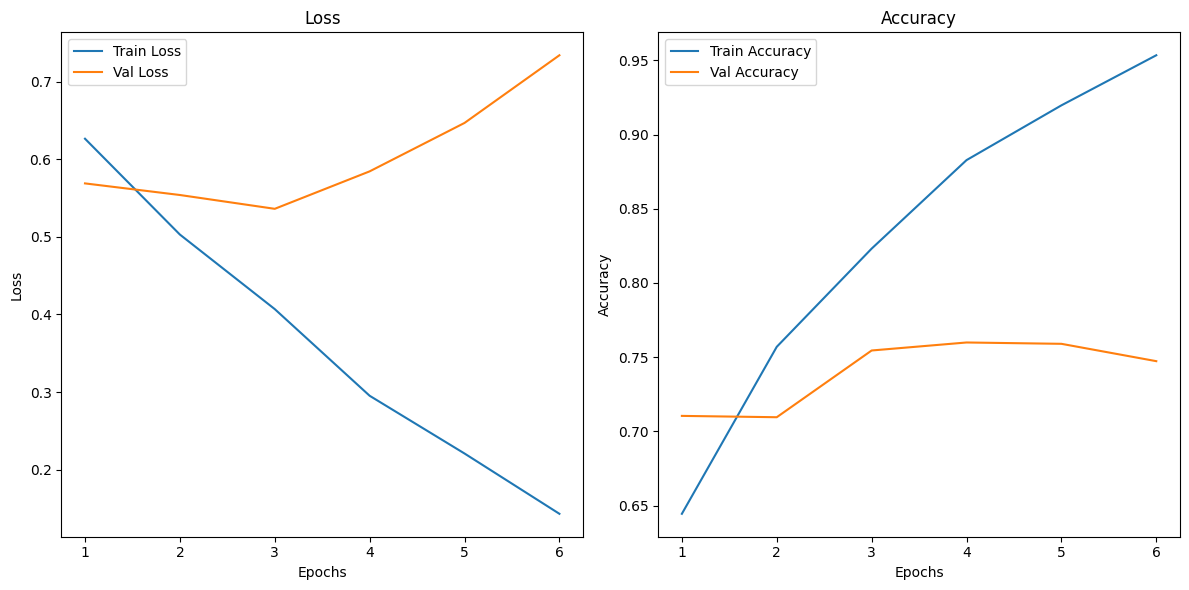

In [11]:
# ==================== CONFIG ====================
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

MAX_LEN = 128
BATCH_SIZE = 16
BERT_MODEL = 'bert-base-uncased'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 20
PATIENCE = 3

# ==================== LOAD GLOVE EMBEDDINGS ====================
captions_glove = np.load('/content/drive/MyDrive/Multimodal-Fake-News-Detection/captions_embeddings.npy')

# ==================== DATASET ====================
class NewsDatasetWithGlove(Dataset):
    def __init__(self, texts, caption_embeddings, labels, tokenizer, max_len):
        self.texts = texts
        self.caption_embeddings = caption_embeddings
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        caption_embed = self.caption_embeddings[idx]

        text_inputs = self.tokenizer(text, padding='max_length', truncation=True,
                                     max_length=self.max_len, return_tensors="pt")

        return {
            'text_input_ids': text_inputs['input_ids'].squeeze(0),
            'text_attention_mask': text_inputs['attention_mask'].squeeze(0),
            'caption_embed': torch.tensor(caption_embed, dtype=torch.float),
            'label': torch.tensor(label, dtype=torch.long)
        }

# ==================== MODEL ====================
class EarlyFusionClassifierGlove(nn.Module):
    def __init__(self, bert_model):
        super(EarlyFusionClassifierGlove, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model)
        self.dropout = nn.Dropout(0.6)
        self.fc = nn.Linear(self.bert.config.hidden_size + 300, 1)  # 300 = GloVe embedding size

    def forward(self, text_ids, text_mask, caption_embed):
        text_output = self.bert(input_ids=text_ids, attention_mask=text_mask).pooler_output
        fused = torch.cat((text_output, caption_embed), dim=1)
        fused = self.dropout(fused)
        return self.fc(fused)

# ==================== EARLY STOPPING ====================
class EarlyStopping:
    def __init__(self, patience=PATIENCE, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# ==================== TRAINING FUNCTIONS ====================
def train_epoch_glove(model, data_loader, loss_fn, optimizer):
    model.train()
    total_loss, correct = 0, 0

    for batch in data_loader:
        text_ids = batch['text_input_ids'].to(DEVICE)
        text_mask = batch['text_attention_mask'].to(DEVICE)
        caption_embed = batch['caption_embed'].to(DEVICE)
        labels = batch['label'].to(DEVICE)

        outputs = model(text_ids, text_mask, caption_embed).squeeze(-1)
        loss = loss_fn(outputs, labels.float())

        preds = torch.sigmoid(outputs) > 0.5
        correct += (preds == labels).sum().item()
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return correct / len(data_loader.dataset), total_loss / len(data_loader)

def evaluate_glove(model, data_loader, loss_fn):
    model.eval()
    total_loss, correct = 0, 0

    with torch.no_grad():
        for batch in data_loader:
            text_ids = batch['text_input_ids'].to(DEVICE)
            text_mask = batch['text_attention_mask'].to(DEVICE)
            caption_embed = batch['caption_embed'].to(DEVICE)
            labels = batch['label'].to(DEVICE)

            outputs = model(text_ids, text_mask, caption_embed).squeeze(-1)
            loss = loss_fn(outputs, labels.float())
            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == labels).sum().item()
            total_loss += loss.item()

    return correct / len(data_loader.dataset), total_loss / len(data_loader)

# ==================== MAIN FUNCTION ====================
def main(csv_path):
    df = pd.read_csv(csv_path)
    df = df.reset_index(drop=True)
    df = df.dropna(subset=['text', 'caption', 'label'])

    glove_embeddings = np.load('/content/drive/MyDrive/Multimodal-Fake-News-Detection/captions_embeddings.npy')

    print(f"Length of dataframe: {len(df)}")
    print(f"Length of embeddings: {glove_embeddings.shape[0]}")
    assert len(df) == glove_embeddings.shape[0], "Mismatch between DataFrame rows and embeddings length!"

    train_texts, val_texts, train_glove, val_glove, train_labels, val_labels = train_test_split(
        df['text'], glove_embeddings, df['label'], test_size=0.2, random_state=42)

    train_texts = train_texts.reset_index(drop=True)
    val_texts = val_texts.reset_index(drop=True)
    train_labels = train_labels.reset_index(drop=True)
    val_labels = val_labels.reset_index(drop=True)

    print(f"Train texts length: {len(train_texts)}, Train glove embeddings length: {train_glove.shape[0]}")
    print(f"Validation texts length: {len(val_texts)}, Validation glove embeddings length: {val_glove.shape[0]}")

    tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)

    train_dataset = NewsDatasetWithGlove(train_texts, train_glove, train_labels, tokenizer, MAX_LEN)
    val_dataset = NewsDatasetWithGlove(val_texts, val_glove, val_labels, tokenizer, MAX_LEN)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    model = EarlyFusionClassifierGlove(BERT_MODEL).to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=5e-3)
    loss_fn = nn.BCEWithLogitsLoss()
    early_stopping = EarlyStopping(patience=PATIENCE, verbose=True)

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch + 1}/{EPOCHS}")
        train_acc, train_loss = train_epoch_glove(model, train_loader, loss_fn, optimizer)
        val_acc, val_loss = evaluate_glove(model, val_loader, loss_fn)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Train Acc: {train_acc:.4f}, Train Loss: {train_loss:.4f}")
        print(f"Val   Acc: {val_acc:.4f}, Val   Loss: {val_loss:.4f}")

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("⛔ Early stopping triggered.")
            break

    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Val Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# ==================== RUN ====================
if __name__ == "__main__":
    main("/content/drive/MyDrive/Multimodal-Fake-News-Detection/merged_dataset.csv")


text       0
caption    0
label      0
dtype: int64
Epoch 1/20
Train Accuracy = 0.6028, Train Loss = 0.6507
Val Accuracy = 0.7122, Val Loss = 0.5589
Epoch 2/20
Train Accuracy = 0.7491, Train Loss = 0.5156
Val Accuracy = 0.7491, Val Loss = 0.5049
Epoch 3/20
Train Accuracy = 0.8218, Train Loss = 0.4101
Val Accuracy = 0.7536, Val Loss = 0.5156
EarlyStopping counter: 1 out of 3
Epoch 4/20
Train Accuracy = 0.8756, Train Loss = 0.3109
Val Accuracy = 0.7581, Val Loss = 0.5498
EarlyStopping counter: 2 out of 3
Epoch 5/20
Train Accuracy = 0.9239, Train Loss = 0.2088
Val Accuracy = 0.7473, Val Loss = 0.6534
EarlyStopping counter: 3 out of 3
Early stopping triggered. Stopping training.


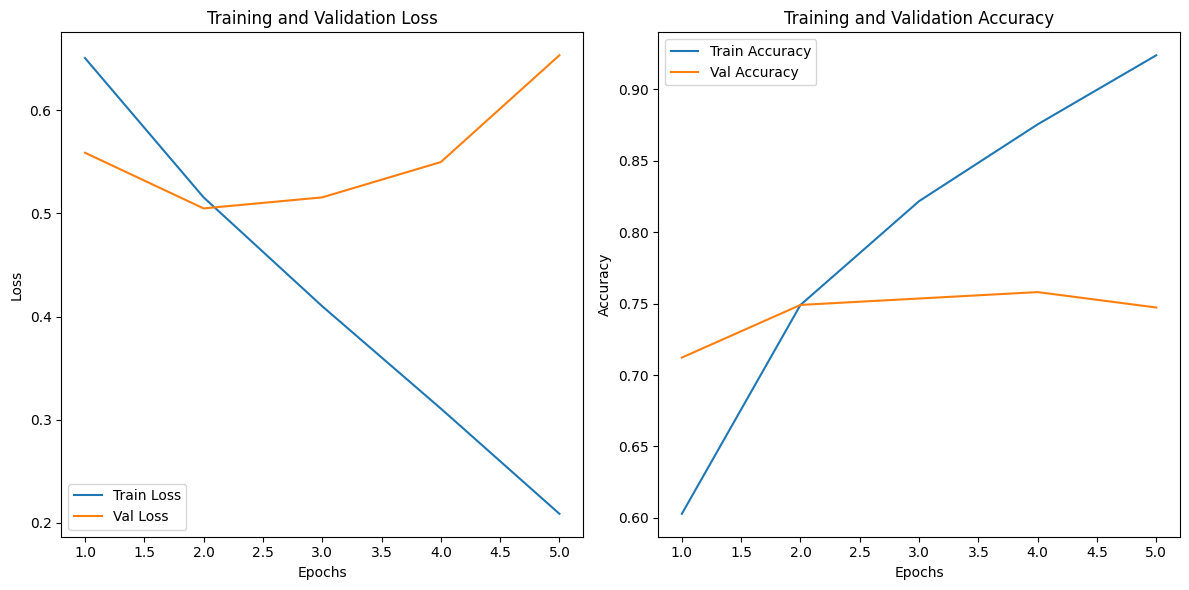

In [12]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

MAX_LEN = 128
BATCH_SIZE = 16
BERT_MODEL = 'bert-base-uncased'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 20
PATIENCE = 3

class NewsDataset(Dataset):
    def __init__(self, texts, captions, labels, tokenizer, max_len):
        self.texts = texts
        self.captions = captions
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        caption = str(self.captions[item])
        label = int(self.labels[item])

        text_inputs = self.tokenizer(text, padding='max_length', truncation=True,
                                     max_length=self.max_len, return_tensors="pt")
        caption_inputs = self.tokenizer(caption, padding='max_length', truncation=True,
                                        max_length=self.max_len, return_tensors="pt")

        return {
            'text_input_ids': text_inputs['input_ids'].squeeze(0),
            'text_attention_mask': text_inputs['attention_mask'].squeeze(0),
            'caption_input_ids': caption_inputs['input_ids'].squeeze(0),
            'caption_attention_mask': caption_inputs['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

class EarlyFusionClassifier(nn.Module):
    def __init__(self, bert_model):
        super(EarlyFusionClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model)
        self.dropout = nn.Dropout(0.6)
        self.fc = nn.Linear(self.bert.config.hidden_size * 2, 1)

    def forward(self, text_ids, text_mask, caption_ids, caption_mask):
        text_output = self.bert(input_ids=text_ids, attention_mask=text_mask).pooler_output
        caption_output = self.bert(input_ids=caption_ids, attention_mask=caption_mask).pooler_output
        fused = torch.cat((text_output, caption_output), dim=1)
        fused = self.dropout(fused)
        out = self.fc(fused)
        return out

def train_epoch(model, data_loader, loss_fn, optimizer):
    model.train()
    losses = []
    correct = 0

    for batch in data_loader:
        text_ids = batch['text_input_ids'].to(DEVICE)
        text_mask = batch['text_attention_mask'].to(DEVICE)
        caption_ids = batch['caption_input_ids'].to(DEVICE)
        caption_mask = batch['caption_attention_mask'].to(DEVICE)
        labels = batch['label'].to(DEVICE)

        outputs = model(text_ids, text_mask, caption_ids, caption_mask).squeeze(-1)
        loss = loss_fn(outputs, labels.float())

        preds = torch.sigmoid(outputs) > 0.5
        correct += (preds == labels).sum().item()
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return correct / len(data_loader.dataset), sum(losses) / len(losses)

def evaluate(model, data_loader, loss_fn):
    model.eval()
    correct = 0
    losses = []

    with torch.no_grad():
        for batch in data_loader:
            text_ids = batch['text_input_ids'].to(DEVICE)
            text_mask = batch['text_attention_mask'].to(DEVICE)
            caption_ids = batch['caption_input_ids'].to(DEVICE)
            caption_mask = batch['caption_attention_mask'].to(DEVICE)
            labels = batch['label'].to(DEVICE)

            outputs = model(text_ids, text_mask, caption_ids, caption_mask).squeeze(-1)
            loss = loss_fn(outputs, labels.float())
            losses.append(loss.item())

            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == labels).sum().item()

    accuracy = correct / len(data_loader.dataset)
    avg_loss = sum(losses) / len(losses)
    return accuracy, avg_loss

class EarlyStopping:
    def __init__(self, patience=PATIENCE, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def main(csv_path):
    df = pd.read_csv(csv_path)
    df = df.reset_index(drop=True)
    print(df[['text', 'caption', 'label']].isnull().sum())
    df = df.dropna(subset=['text', 'caption', 'label'])

    train_texts, val_texts, train_captions, val_captions, train_labels, val_labels = train_test_split(
        df['text'], df['caption'], df['label'], test_size=0.2, random_state=42)

    train_texts = train_texts.reset_index(drop=True)
    val_texts = val_texts.reset_index(drop=True)
    train_captions = train_captions.reset_index(drop=True)
    val_captions = val_captions.reset_index(drop=True)
    train_labels = train_labels.reset_index(drop=True)
    val_labels = val_labels.reset_index(drop=True)

    tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)

    train_dataset = NewsDataset(train_texts, train_captions, train_labels, tokenizer, MAX_LEN)
    val_dataset = NewsDataset(val_texts, val_captions, val_labels, tokenizer, MAX_LEN)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    model = EarlyFusionClassifier(BERT_MODEL).to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=5e-3)
    loss_fn = nn.BCEWithLogitsLoss()

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

    early_stopping = EarlyStopping(patience=PATIENCE, verbose=True)

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(EPOCHS):
        print(f"Epoch {epoch + 1}/{EPOCHS}")
        train_acc, train_loss = train_epoch(model, train_loader, loss_fn, optimizer)
        val_acc, val_loss = evaluate(model, val_loader, loss_fn)

        scheduler.step(val_loss)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Train Accuracy = {train_acc:.4f}, Train Loss = {train_loss:.4f}")
        print(f"Val Accuracy = {val_acc:.4f}, Val Loss = {val_loss:.4f}")

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered. Stopping training.")
            break

    epochs_range = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main("/content/drive/MyDrive/Multimodal-Fake-News-Detection/merged_dataset.csv")


text       0
caption    0
label      0
dtype: int64


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20
Train Accuracy = 0.5029, Train Loss = 0.7070
Val Accuracy = 0.4838, Val Loss = 0.6939
Epoch 2/20
Train Accuracy = 0.5335, Train Loss = 0.6909
Val Accuracy = 0.6897, Val Loss = 0.6175
Epoch 3/20
Train Accuracy = 0.7018, Train Loss = 0.5663
Val Accuracy = 0.7545, Val Loss = 0.5235
Epoch 4/20
Train Accuracy = 0.7568, Train Loss = 0.4925
Val Accuracy = 0.7716, Val Loss = 0.4873
Epoch 5/20
Train Accuracy = 0.7975, Train Loss = 0.4324
Val Accuracy = 0.7617, Val Loss = 0.4851
Epoch 6/20
Train Accuracy = 0.8324, Train Loss = 0.3726
Val Accuracy = 0.7590, Val Loss = 0.5247
EarlyStopping counter: 1 out of 3
Epoch 7/20
Train Accuracy = 0.8747, Train Loss = 0.3005
Val Accuracy = 0.7491, Val Loss = 0.5480
EarlyStopping counter: 2 out of 3
Epoch 8/20
Train Accuracy = 0.9014, Train Loss = 0.2371
Val Accuracy = 0.7689, Val Loss = 0.6182
EarlyStopping counter: 3 out of 3
Early stopping triggered. Stopping training.


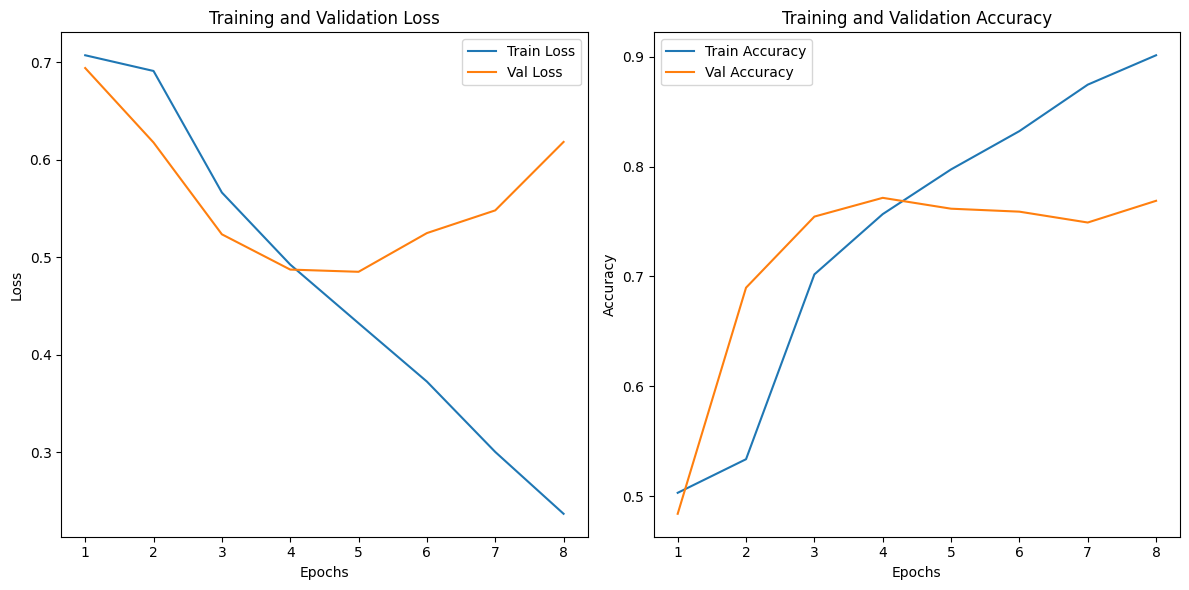

In [14]:
import torch
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaModel
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

MAX_LEN = 128
BATCH_SIZE = 16
ROBERTA_MODEL = 'roberta-large'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 20
PATIENCE = 3

class NewsDataset(Dataset):
    def __init__(self, texts, captions, labels, tokenizer, max_len):
        self.texts = texts
        self.captions = captions
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        caption = str(self.captions[item])
        label = int(self.labels[item])

        text_inputs = self.tokenizer(text, padding='max_length', truncation=True,
                                     max_length=self.max_len, return_tensors="pt")
        caption_inputs = self.tokenizer(caption, padding='max_length', truncation=True,
                                        max_length=self.max_len, return_tensors="pt")

        return {
            'text_input_ids': text_inputs['input_ids'].squeeze(0),
            'text_attention_mask': text_inputs['attention_mask'].squeeze(0),
            'caption_input_ids': caption_inputs['input_ids'].squeeze(0),
            'caption_attention_mask': caption_inputs['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

class EarlyFusionClassifier(nn.Module):
    def __init__(self, roberta_model):
        super(EarlyFusionClassifier, self).__init__()
        self.roberta = RobertaModel.from_pretrained(roberta_model)
        self.dropout = nn.Dropout(0.6)
        self.fc = nn.Linear(self.roberta.config.hidden_size * 2, 1)

    def forward(self, text_ids, text_mask, caption_ids, caption_mask):
        text_output = self.roberta(input_ids=text_ids, attention_mask=text_mask).pooler_output
        caption_output = self.roberta(input_ids=caption_ids, attention_mask=caption_mask).pooler_output
        fused = torch.cat((text_output, caption_output), dim=1)
        fused = self.dropout(fused)
        out = self.fc(fused)
        return out

def train_epoch(model, data_loader, loss_fn, optimizer):
    model.train()
    losses = []
    correct = 0

    for batch in data_loader:
        text_ids = batch['text_input_ids'].to(DEVICE)
        text_mask = batch['text_attention_mask'].to(DEVICE)
        caption_ids = batch['caption_input_ids'].to(DEVICE)
        caption_mask = batch['caption_attention_mask'].to(DEVICE)
        labels = batch['label'].to(DEVICE)

        outputs = model(text_ids, text_mask, caption_ids, caption_mask).squeeze(-1)
        loss = loss_fn(outputs, labels.float())

        preds = torch.sigmoid(outputs) > 0.5
        correct += (preds == labels).sum().item()
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return correct / len(data_loader.dataset), sum(losses) / len(losses)

def evaluate(model, data_loader, loss_fn):
    model.eval()
    correct = 0
    losses = []

    with torch.no_grad():
        for batch in data_loader:
            text_ids = batch['text_input_ids'].to(DEVICE)
            text_mask = batch['text_attention_mask'].to(DEVICE)
            caption_ids = batch['caption_input_ids'].to(DEVICE)
            caption_mask = batch['caption_attention_mask'].to(DEVICE)
            labels = batch['label'].to(DEVICE)

            outputs = model(text_ids, text_mask, caption_ids, caption_mask).squeeze(-1)
            loss = loss_fn(outputs, labels.float())
            losses.append(loss.item())

            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == labels).sum().item()

    accuracy = correct / len(data_loader.dataset)
    avg_loss = sum(losses) / len(losses)
    return accuracy, avg_loss

class EarlyStopping:
    def __init__(self, patience=PATIENCE, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def main(csv_path):
    df = pd.read_csv(csv_path)
    df = df.reset_index(drop=True)
    print(df[['text', 'caption', 'label']].isnull().sum())
    df = df.dropna(subset=['text', 'caption', 'label'])

    train_texts, val_texts, train_captions, val_captions, train_labels, val_labels = train_test_split(
        df['text'], df['caption'], df['label'], test_size=0.2, random_state=42)

    train_texts = train_texts.reset_index(drop=True)
    val_texts = val_texts.reset_index(drop=True)
    train_captions = train_captions.reset_index(drop=True)
    val_captions = val_captions.reset_index(drop=True)
    train_labels = train_labels.reset_index(drop=True)
    val_labels = val_labels.reset_index(drop=True)

    tokenizer = RobertaTokenizer.from_pretrained(ROBERTA_MODEL)

    train_dataset = NewsDataset(train_texts, train_captions, train_labels, tokenizer, MAX_LEN)
    val_dataset = NewsDataset(val_texts, val_captions, val_labels, tokenizer, MAX_LEN)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    model = EarlyFusionClassifier(ROBERTA_MODEL).to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=5e-3)
    loss_fn = nn.BCEWithLogitsLoss()

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

    early_stopping = EarlyStopping(patience=PATIENCE, verbose=True)

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(EPOCHS):
        print(f"Epoch {epoch + 1}/{EPOCHS}")
        train_acc, train_loss = train_epoch(model, train_loader, loss_fn, optimizer)
        val_acc, val_loss = evaluate(model, val_loader, loss_fn)

        scheduler.step(val_loss)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Train Accuracy = {train_acc:.4f}, Train Loss = {train_loss:.4f}")
        print(f"Val Accuracy = {val_acc:.4f}, Val Loss = {val_loss:.4f}")

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered. Stopping training.")
            break

    epochs_range = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main("/content/drive/MyDrive/Multimodal-Fake-News-Detection/merged_dataset.csv")
